# Análisis de datos de IM por medio de la matriz de grado

In [1]:
import sys 

import numpy as np
import pandas as pd 
import networkx as nx
import math
import sympy as sp
import matplotlib.pyplot as plt

np.set_printoptions(threshold=sys.maxsize)

from sympy import *
from numpy import linalg as LA
from numpy.linalg import matrix_rank

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ="all"

In [2]:
#Establecer directorio de datos

DIR='/Users/alex/Desktop/MatrizAdjSano/MatrizAdjSano'
FILE='/adjmatrix_UNS.txt'

file='{}{}'.format(DIR,FILE)

print('File directory:{}'.format(file))

File directory:/Users/alex/Desktop/MatrizAdjSano/MatrizAdjSano/adjmatrix_UNS.txt


In [3]:
data=pd.read_table(file)

In [4]:
data.head()

,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000001036,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,...,hsa-mir-941-5,hsa-mir-942,hsa-mir-943,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
0,1.0,0.103197,0.152306,0.107439,0.151863,0.050207,0.047916,0.152306,0.162813,0.032128,...,0.038779,0.016197,0.052990,0.062391,0.070298,0.038779,0.044215,0.259474,0.151107,0.074188
1,NaN,1.000000,0.120830,0.128810,0.121863,0.076382,0.064962,0.120830,0.250164,0.102605,...,0.108833,0.124237,0.120423,0.125844,0.020272,0.108833,0.127723,0.069236,0.199134,0.112418
2,NaN,NaN,1.000000,0.051569,0.107554,0.057486,0.038834,0.334130,0.248721,0.048574,...,0.059112,0.044184,0.051950,0.091854,0.071886,0.059112,0.030633,0.097257,0.045373,0.075525
3,NaN,NaN,NaN,1.000000,0.032182,0.069682,0.042741,0.051569,0.126349,0.051244,...,0.054916,0.133838,0.062266,0.132682,0.021764,0.054916,0.103477,0.123546,0.184396,0.057522
4,NaN,NaN,NaN,NaN,1.000000,0.214658,0.029944,0.107554,0.108194,0.094873,...,0.102947,0.156264,0.069491,0.128388,0.018218,0.102947,0.094818,0.178692,0.051804,0.064486


In [5]:
a=np.diag(np.ones(16748),0)
A=data-a

In [6]:
#Este modulo calcula un valor umbral ("threshold") que promedia todos los valores de las 
# entradas de un data set

# Función convertir a lista el resultado de aplicar .mean() a un DataFrame

def mean_to_list(df):
    arr=[]
    for i in range(0,len(df)):
        a=df.iloc[i]
        arr.append(a)
    return arr

# Función para calcular el promedio de las entradas de una lista 

def cal_prom_en_list(num):
    sum_num=0
    for entrada in num:
        sum_num=sum_num +entrada
        
    prom = sum_num/len(num)
    return prom

# Cálculo del umbral, promediando sobre todas las entradas de la matriz de adyacencia

A_prom_cols=A.mean()
A_mean_list=mean_to_list(A_prom_cols)
cal_prom_en_list(A_mean_list)
threshold=cal_prom_en_list(A_mean_list)

In [7]:
threshold

0.08567775225309081

In [8]:
#Función para contruir la matriz de grado a partir de la de la matriz de adyacencia

def degreeMat_from_Adj(mat,n):
    new_data=mat.iloc[:n,:n]
    
    new_data2=new_data.apply(lambda x:(np.where(x<threshold,0,x)))
    adj_mat=new_data2.apply(lambda x:(np.where(x>threshold,1,x)))
    
    #completar la matriz triangular superior para tener la forma completa de una matriz
    # simétrica
    
    adj_mod=np.matrix(adj_mat.fillna(0))
    adj_mod_trans=adj_mod.transpose()
    simm_mat=adj_mod+adj_mod_trans    #type(simm_mat)=numpy matrix
    
    
    Adj_to_nx=nx.from_numpy_matrix(simm_mat)
    L_from_Adj=nx.laplacian_matrix(Adj_to_nx) #obtener la Laplaciana asociada a la de adyacencia
    
    L_arr=L_from_Adj.toarray()
    
    L_np=np.matrix(L_arr)
    
    deg_Mat=L_np+simm_mat
    
    return deg_Mat

In [9]:
# El siguiente módulo, crea un array con los primeros "n" genes que deseen obtener del
# Data Frame "data"

#Parametros: data , n 

def get_genes(data,n):
    
    genes_arr = sorted(data) #obtener un array que contiene los elementos del header del DataFrame
    num_genes_extracted = range(n)
    genes = np.array(genes_arr)[num_genes_extracted]
    
    return genes

In [10]:
#Este script es capaz de dibujar el grafo con sus vértices respectivos etiquetados

#Este módulo ha sifo modificado para que sea capaz de etiquetar los nombres de los genes 
#involucrados

def plt_with_label(mat,n):
    
    new_data=mat.iloc[:n,:n]
    
    new_data2=new_data.apply(lambda x:(np.where(x<threshold,0,x)))
    adj_mat=new_data2.apply(lambda x:(np.where(x>threshold,1,x)))
    
    #completar la matriz triangular superior para tener la forma completa de una matriz
    # simétrica
    
    adj_mod=np.matrix(adj_mat.fillna(0))
    adj_mod_trans=adj_mod.transpose()
    simm_mat=adj_mod+adj_mod_trans
    adj_to_graph=nx.from_numpy_matrix(simm_mat)
    
    labelmap=dict(zip(adj_to_graph.nodes(),get_genes(data,n))) # el primer parámetro es 
    #el grupo de nodos que será manipulado y el segundo todos los nombres o etiquetas que se usaran
    
    plt.figure(1,figsize=(12,12))
    nx.draw(adj_to_graph, labels=labelmap, with_labels=True,
    font_size=7,font_weight='bold',font_color='green',edge_color='gray',node_color='blue')
    
    
    
    graph_with_lab=plt.show()
    
    return graph_with_lab

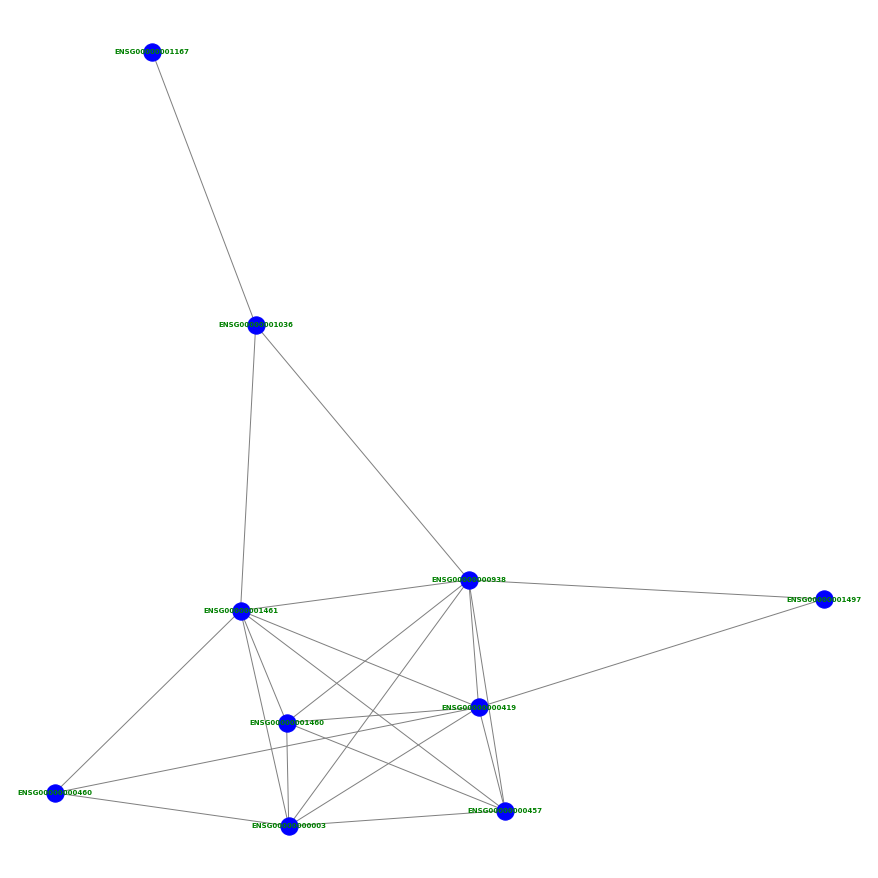

In [12]:
plt_with_label(A,10)

In [13]:
Mat_p=degreeMat_from_Adj(A,4)

In [11]:
#La siguiente función sirve para obtener los elementos de la diagonal de la matriz de
# grado y la guarda en un array llamado out_p


def get_elem_in_diag(Mat):
    Mat_mod = np.squeeze(np.asarray(Mat))#convierte numpy matrix en array
    out_p=[]
    for elem in np.nditer(Mat_mod): #nditer itera sobre arrays
        if elem != 0: # omite los valores 0 en el array pues la matriz de grado fuera de la diagonal tiene solo ceros
            out_p.append(int(elem))
            
    return out_p 
    

In [12]:
#Función para obtener el número mayor de una lista de números dentro de un array

# El parámetro debe tener el mismo número que la dimensión de la matriz 
# de grado que se está analizando

#def get_biggest_num_in_diag(l,n):
#    count=0
#    for i in range(n):
#        for j in range(n):
#            if l[j]>l[i]:
#                count=l[j]
#    return count   

# En la siguiente función el parámetro "a" es un array que contiene los elementos de 
# la diagonal de la matriz de grado y "N" es el número de elementos que se tomará para
# ordenarlos de mayor a menor.

# El output indica la posición de la entrada y no su valor, pues con ello podremos 
# identificar cuál es el gen que tiene más aristas incidentes dentro de él 

def func(a,N):
    return np.argsort(a)[::-1][:N]

In [13]:
func(get_elem_in_diag(degreeMat_from_Adj(A,100)),100)

array([77, 12, 32, 91, 73, 93, 83, 44, 65, 43, 51, 34, 54,  0, 19, 60, 39,
       29,  8, 55,  1, 13, 48, 57, 78, 75, 74, 49, 76, 90,  3, 89, 45, 37,
       70, 26, 62, 33, 98, 20, 63, 92, 85, 96, 82,  6, 24, 22, 40, 88, 23,
       17, 68, 47, 61, 35, 42,  5, 79,  7, 64,  2, 87, 14, 71, 72, 59, 50,
       80, 84, 97, 95, 94, 99, 16, 41, 58, 11, 15, 56, 31, 46, 25, 21, 53,
       10, 30, 52, 66,  9,  4, 69, 81, 18, 28, 67, 36, 38, 27, 86])

In [1]:
func(get_elem_in_diag(degreeMat_from_Adj(A,100)),100)

NameError: name 'func' is not defined

In [19]:
func(get_elem_in_diag(degreeMat_from_Adj(A,1000)),1000)

array([237, 658, 296, 213, 436, 244, 861,  77, 592, 486,  32, 327,  54,
       992, 488, 226, 332, 940, 565, 811, 834, 690, 386, 764, 927, 380,
        29, 275, 991, 554, 773, 576,  65, 841,  73,  93, 314, 892, 106,
       638, 193, 657, 602, 953, 379, 758, 640, 852, 771, 667, 518,  83,
       648, 663, 438, 382, 702, 603, 331, 637, 541,  43, 713, 598, 417,
       888, 166, 616, 631, 754, 340, 957, 682, 604, 933, 320,  55, 875,
       641, 783, 140, 472, 476, 183,  51, 555, 463, 714, 934,  57, 240,
        12,  91, 390, 542, 924, 722,  78, 843, 551, 155, 274, 882, 620,
       232,  44, 575,  75, 650, 801, 952,   3, 440, 660, 187, 747,  34,
       571, 424, 805, 972, 480, 378, 334, 453, 617, 880, 391, 268, 685,
       757, 820, 315, 652, 504, 157, 399, 583, 439, 701, 949, 257, 124,
       530, 225, 905, 946, 404, 283, 717, 694, 136, 794, 113, 550, 238,
       267, 169, 826, 768, 732, 184, 168, 958, 128, 185, 153, 422, 836,
       644, 403, 363, 284, 192, 673, 503, 569, 980, 566, 922, 60

In [13]:
func(get_elem_in_diag(degreeMat_from_Adj(A,2000)),2000)

array([1222,  658,  237, 1366,  436, 1481,  296,  861,   32,  213,  244,
         77,  592,   54,  811, 1875, 1992, 1696, 1643, 1601,  565,  332,
       1421, 1014,  992, 1122,  488, 1750,  486, 1631, 1016, 1070,  327,
       1647, 1254,  834,  690, 1904, 1237, 1440,   29, 1517, 1261, 1031,
        940,  386, 1221,   73,   65, 1618, 1975, 1966, 1118, 1196, 1002,
        226,  657,  702,  927, 1382, 1359, 1695, 1512,  764,   93, 1052,
       1773,  892,  380, 1545,  663, 1902,  773,  106, 1520, 1712,  771,
       1615,  638, 1542, 1092,  518,  275, 1267, 1251, 1879, 1510, 1047,
       1937, 1739, 1452,   43,  841, 1513,  640,  379, 1719,  758, 1829,
        991, 1128,  554,   83, 1423, 1387,  417, 1321,  682, 1823,  340,
        314, 1049, 1504,  641,  331,  713,  576, 1153, 1749,  480,  933,
       1806,  603, 1348, 1515,  193, 1453, 1323, 1200,  783,  382,  476,
       1781,  667,   51,  953, 1939, 1425,  631,  852, 1125,  648, 1675,
       1242,  714,  391, 1100, 1924,  602,  240,  5

In [14]:
func(get_elem_in_diag(degreeMat_from_Adj(A,3000)),3000)

array([1222,  658,  237, 2370, 2124, 1481,  861, 2149,   32,  811, 1366,
        436, 2369, 2841, 2702, 2626,  565,  296,  213, 1875, 2653, 2422,
       2953,  244, 1601,  992,  486, 2313,   54, 2776, 2753, 2734, 1421,
       1016, 2818, 2804, 2071, 2636, 1696, 1750,  690, 1517, 1992,   77,
       1647, 2454, 1261, 2012, 1070, 1904, 2586,  592, 1237,  834, 2072,
       2667,  488,   29, 2289, 2572, 2451,  332, 1031,   65,   73, 2826,
       1966, 2891,  940, 1631, 2901, 2877, 1643, 1118, 1975,  702,  226,
       2106,  327, 1196, 1122, 2893,   93, 2341, 1440, 1014,  386, 1002,
       1359, 1382,  771, 1545, 1695, 2519, 1618, 1221, 1510,  657, 1719,
        892,  663, 2244,  638,  518, 2956,  764, 2584,  773, 2429, 2990,
       1267, 1254, 2381,  380, 2350, 1512, 1153,  758, 1615, 2979, 1092,
       2762, 2856, 2328, 1902, 1052, 1452, 2176, 2115,  340, 2627, 1251,
        476,  933,  417,  927, 2164,  991,  379,  841,   43, 2343, 1781,
       2358, 1739,   83, 1712, 1128, 2982, 2400,  6

In [15]:
func(get_elem_in_diag(degreeMat_from_Adj(A,4000)),4000)

array([1222, 3696, 3103, 2370, 1481,  658, 2124,  237, 1366, 3529, 3269,
        861, 2149,  436, 3918,   32, 2626, 2841,  811, 2702, 2369, 1875,
        296, 1601, 3181,  486,  565, 2653, 2753,  213, 3312, 2636,   77,
        244, 2422, 3622, 2804, 3500,  992, 2072, 2818, 1421, 2953, 1992,
       2734, 3506, 3819, 3879, 2454,   54, 3394, 2012, 2071, 1261, 1070,
        690, 2313, 1647, 1643, 3554, 2289, 3537, 3565,  592, 2572, 2826,
       2891, 2667, 2586,   65, 1750, 1237, 1014, 3098, 1517,  834,  327,
       3694, 1696, 2901,   29, 1016, 1904, 3322, 2106,   73, 2776, 3605,
       2956, 3801, 3341, 3616,  940, 2451, 1122, 1267, 1631,   93, 2877,
       1440, 3723, 1545, 1196,  702,  638,  773, 3386, 1695, 3558, 3541,
       2244, 1221,  332, 1966, 2341,  518, 2893, 2584, 1031, 3795, 1975,
       1118,  488, 1359, 3759, 1092, 3183, 3816,  771, 1251,  764, 3007,
       3615, 2762,  380,  892, 2519, 2328, 3941,  663, 3167, 1618, 3165,
       2979, 2350, 2990, 1002, 3399, 2115, 1510,  3

In [16]:
func(get_elem_in_diag(degreeMat_from_Adj(A,5000)),5000)

array([1222, 3696, 3103, 2124,  237,  658, 1481, 4103, 3529, 2370, 4192,
       1366, 4427,  861, 3269, 2149, 3918,  811,  436, 2369, 4489,   32,
        296, 4715, 4298, 3181, 2626, 2841,  213, 2653,  992,   77, 4497,
       3500, 1875, 4452, 2702, 4306, 1601, 4950, 2753, 2734, 2636, 3506,
        486, 4525, 4648, 4842, 2422, 3879, 2804, 3312,  565, 2012, 1261,
       3554, 1992, 4232, 2072, 3819,  244, 3622, 2818, 3394, 4413, 4625,
       4568, 1421, 2953, 2071, 2572, 2313, 2289, 4339,  690,   54, 4458,
       3537, 1647, 2901, 4608, 2454, 1696, 4164, 1517, 1643, 1070, 3694,
       4917, 4158, 2826, 1750, 4955, 2667,  592,   65, 2586, 4235, 3565,
       2891, 1014, 1016, 3541, 3386, 1267, 4722, 1904,  332, 1237, 3801,
       3322,  327, 4743,  834,   29, 2776, 1122, 4424,   73, 4002, 1631,
       3098, 3558, 3341, 1440,   93, 3723, 4352, 2451, 3183,  702, 1118,
       4099, 1031, 1975, 2893,  518, 4423, 2244, 4136, 2877, 1545, 3795,
        940, 1196, 3605,  488, 1251, 3616, 2106, 13

In [17]:
func(get_elem_in_diag(degreeMat_from_Adj(A,6000)),6000)

array([5341, 1222, 3696, 2124, 5762, 3103,  658,  237, 4427, 1481, 5481,
       3529, 4192,  861, 2370, 5232, 4103, 3269, 1366, 2369, 4489,  811,
       5971,  296, 2149, 3918,   32,  436, 4715, 3181, 4298,  213,  992,
       5852, 2626, 4497, 2841,   77, 5203, 3500, 5184, 2653, 3506, 4452,
       3554, 4306, 5648, 2734, 2702, 2804, 1421, 3879, 4842, 2753, 5317,
       1601, 4950, 4625, 1875, 3312,  244, 4525, 4568, 2818,  486,  565,
       2072, 4232, 2313, 4458, 2636, 3394, 2572, 1992, 1261, 2012, 2953,
       2422, 4648, 3622, 1016, 1696, 4413, 3819, 2289,  690,  332, 1750,
       4339,   54, 2071, 2826, 1517, 1237, 3694, 1070, 2901, 2667, 4158,
       4917, 3537, 4164, 2454, 3541, 3565, 3386, 4608, 5181, 5669, 5108,
       1647, 1014, 1643, 3801, 5372, 5873, 5783, 2586,  592, 1267, 4722,
         65, 4955, 4235, 2891, 1631, 5581, 2776, 4424, 2451, 5115,   29,
       3795, 5010, 5917, 3341, 3723, 5245,  940, 1031, 1904, 3322, 3183,
       1122,  834, 3098, 2893, 1196, 4352, 4743,  3

In [25]:
func(get_elem_in_diag(degreeMat_from_Adj(A,7000)),7000)

array([6344, 5341, 1222, ..., 1724, 5105, 1797])

In [17]:
func(get_elem_in_diag(degreeMat_from_Adj(A,8000)),8000)

array([6344, 5341, 1222, ..., 5105, 7188, 1797])

In [26]:
func(get_elem_in_diag(degreeMat_from_Adj(A,9000)),9000)

array([6344, 5341, 1222, ..., 7188, 1797, 5105])

In [27]:
func(get_elem_in_diag(degreeMat_from_Adj(A,10)),10)

array([8, 4, 1, 0, 7, 2, 5, 3, 9, 6])

In [14]:
func(get_elem_in_diag(degreeMat_from_Adj(A,10000)),10000)

array([6344, 9242, 5341, ..., 8668, 5105, 1797])

In [ ]:
# La siguiente función ayuda a encontrar qué genes corresponden 
# a la posición proporcionada por la función  "func"

In [28]:
def get_genes(data,n):
    
    genes_arr = sorted(data) #obtener un array que contiene los elementos del header del DataFrame
    num_genes_extracted = range(n)
    genes = np.array(genes_arr)[num_genes_extracted]
    
    return genes

In [31]:
get_genes(data,16748) # nos proporciona un array con los nombres de los 16748 genes 
# de la matriz de adyacencia

array(['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457', ...,
       'hsa-mir-98', 'hsa-mir-99a', 'hsa-mir-99b'], dtype='<U15')

In [ ]:
# Así al usar la función "func", encontrando la posición de aquellos
# vértices que tienen una mayor cantidad de aristas incidentes dentro de la red 
# vía la matriz de grado ahora, basta con usar get_genes la posición asociada al gen 
# con más cantidad de bordes incidentes en él e identificarlo:

In [35]:
# Por ejemplo para el cálculo hecho con 
# "func(get_elem_in_diag(degreeMat_from_Adj(A,9000)),9000)" se encontró que los 3 genes con 
# mayor cantidad de aristas incidentes son 6344, 5341, 1222, así que bastará con calcular

In [36]:
get_genes(data,16748)[6344]

'ENSG00000137807'

In [37]:
get_genes(data,16748)[5341]

'ENSG00000130635'

In [38]:
get_genes(data,16748)[1222]

'ENSG00000077721'